In [6]:
import torch
import torch.nn as nn
import numpy as np
import os
import yaml
import json
import pandas as pd
import sys
sys.path.append(r"C:\Users\chataint\Documents\projet\humanlisbet\baseline")
from utils import trainer, load_h5_data, load_embedding

In [7]:
class CNN(nn.Module):
    def __init__(self, input_size, sequence_length, num_filters, kernel_size, pool_size, hidden_size, output_size):
        super(CNN, self).__init__()
        
        # 1D Convolutional Layer
        self.conv1 = nn.Conv1d(
            in_channels=input_size,  # Number of keypoints per frame (34)
            out_channels=num_filters,  # Number of filters
            kernel_size=kernel_size  # Width of each filter
        )
        self.relu = nn.ReLU()
        
        # MaxPooling Layer
        self.pool = nn.MaxPool1d(kernel_size=pool_size)
        
        # Calculate the reduced sequence length after convolution and pooling
        conv_output_length = sequence_length - kernel_size + 1  # After convolution
        pooled_length = conv_output_length // pool_size         # After pooling
        
        # Fully connected layers
        self.fc1 = nn.Linear(num_filters * pooled_length, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()  # For binary classification

    def forward(self, x):
        # x: (batch_size, sequence_length, input_size)
        x = x.permute(0, 2, 1)  # Rearrange to (batch_size, input_size, sequence_length)
        x = self.conv1(x)  # Convolution
        x = self.relu(x)   # Activation
        x = self.pool(x)   # MaxPooling
        x = x.flatten(start_dim=1)  # Flatten for fully connected layers
        x = self.relu(self.fc1(x))  # Fully connected layer
        x = self.sigmoid(self.fc2(x))  # Output layer
        return x

In [8]:
def process_data_with_windows(df, window_size=200, stride=30):
    """
    Converts the input dictionary into multiple windows for MLP training.
    
    Args:
        data_dict (dict): Dictionary with video data.
            - Keys: Video IDs
            - Values: {"keypoints": np.array of shape (num_frames, 34), "diag": binary}
        window_size (int): Number of frames per window.
        stride (int): Number of frames to slide for the next window.
        
    Returns:
        X (np.array): Flattened input features for MLP of shape (num_windows, 34 * window_size)
        y (np.array): Binary labels of shape (num_windows,)
    """
    idx_vid, X, y = [], [], []
    
    for video_id, video_data in df.groupby('video'):
        diag = video_data.iloc[0].diagnosis
        vd = video_data.drop(['video', 'diagnosis'], axis=1).to_numpy()
        num_frames= len(vd)
        # Create windows
        for start in range(0, num_frames - 200 + 1, 100):
            window = vd[start : start + 200]
            X.append(window)
            y.append(diag)
            idx_vid.append(video_id)
    
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    
    return idx_vid, X, y

In [9]:
datapath = r"C:\Users\chataint\Documents\projet\humanlisbet\datasets\humans\humans_train_annoted.h5"
dataval = r"C:\Users\chataint\Documents\projet\humanlisbet\datasets\humans\humans_test_annoted.h5"
out = r"C:\Users\chataint\Documents\projet\humanlisbet\baseline\out_cnn"
mapping_path = r"C:\Users\chataint\Documents\projet\humanlisbet\datasets\humans\category_mapping.json"
label_path = r"C:\Users\chataint\Documents\projet\humanlisbet\datasets\humans\humans_annoted.label.json"

os.makedirs(out, exist_ok=True)

In [10]:
# Hyperparameters
INPUT_SIZE = 34  
HIDDEN_SIZE = 128
WINDOW = 200
OUTPUT_SIZE = 1  # Binary classification
LEARNING_RATE = 1e-4
EPOCHS = 500
BATCH_SIZE = 64
seed = 42
test_ratio = 0.8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DROPOUT = 0.3
verbose = False
NUM_FILTER=64
KERNEL_SIZE=30   # look at one second
POOL_SIZE=2

# Parameter dictionary
run_parameters = {
    "input_size": INPUT_SIZE,
    "hidden_size": HIDDEN_SIZE,
    "output_size": OUTPUT_SIZE,
    "window": WINDOW,
    "learning_rate": LEARNING_RATE,
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "seed": seed,
    "test_ratio": test_ratio,
    "dropout": DROPOUT,
    "num_filter": NUM_FILTER,
    "verbose": verbose,
    "kernel_size":KERNEL_SIZE,
    'pool_size':POOL_SIZE
}

with open(os.path.join(out, 'parameters.json'), 'w') as fd:
    json.dump(run_parameters, fd, indent=4)



# Initialize the model, loss, and optimizer
model = CNN(input_size=INPUT_SIZE, sequence_length=WINDOW, num_filters=NUM_FILTER, 
            kernel_size=KERNEL_SIZE, pool_size=POOL_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE).to(device)

dfm = trainer(out, run_parameters, mapping_path, label_path, datapath, device, dataval, model, process_data_with_windows)



Training Progress:   0%|          | 0/500 [00:00<?, ?epoch/s]

AttributeError: 'tuple' object has no attribute 'cpu'

# Training and testing

In [15]:
b

,video,em_0,em_1,em_2,em_3,em_4,em_5,em_6,em_7,em_8,...,em_23,em_24,em_25,em_26,em_27,em_28,em_29,em_30,em_31,diagnosis
0,7772,-2.649589,-1.943590,-1.760673,-0.535619,-0.996935,-2.691397,0.060537,-0.991062,-2.789075,...,-0.253182,-1.683011,-1.350517,-1.415421,-2.828028,-0.512953,0.034894,-0.254609,-3.099549,1
1,7772,-1.505861,-0.637452,-0.920142,-3.377121,-2.275179,-0.841668,0.504525,-0.965362,2.456026,...,-0.804945,-1.562739,-0.956605,-0.810732,-4.857887,-1.183062,-2.264083,-1.988734,-3.075966,1
2,7772,-2.680547,-2.168692,-1.460608,-0.707116,-1.210746,-2.969866,0.425778,-0.905760,-3.334639,...,-0.236879,-1.608085,-1.848440,-1.205590,-3.275496,-1.101208,0.236585,-0.372425,-3.097272,1
3,7772,-1.488259,-0.621500,-1.001408,-3.367252,-2.309075,-0.763964,0.495507,-1.028573,2.522233,...,-0.801072,-1.530368,-0.958967,-0.736516,-4.904916,-1.257329,-2.306789,-2.017292,-2.993465,1
4,7772,-2.685731,-2.028525,-1.521620,-0.619437,-1.078612,-3.119058,0.622871,-0.908907,-3.148997,...,-0.180259,-1.555941,-2.004924,-1.175235,-3.718956,-1.509389,0.332181,-0.734753,-3.121060,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996064,8208,-3.548370,-1.745272,-3.316725,0.508545,-2.726678,-1.875051,0.135440,-1.705706,0.655953,...,-0.628589,-1.160564,-1.901258,-0.254920,-4.419723,-1.453157,-0.985549,0.686243,-2.333239,0
996065,8208,-3.560968,-1.740371,-3.301469,0.498525,-2.729185,-1.861402,0.127274,-1.705351,0.641106,...,-0.636512,-1.153037,-1.874000,-0.276976,-4.446923,-1.447658,-0.974079,0.690658,-2.348269,0
996066,8208,-3.564777,-1.724567,-3.294891,0.493447,-2.724790,-1.829040,0.124084,-1.704815,0.650101,...,-0.632238,-1.137057,-1.867302,-0.299551,-4.466863,-1.450863,-0.983143,0.673321,-2.326455,0
996067,8208,-3.567790,-1.703609,-3.259445,0.468796,-2.800629,-1.745981,0.099459,-1.674888,0.727336,...,-0.645113,-1.130878,-1.888461,-0.300614,-4.491951,-1.491007,-0.982293,0.591772,-2.233817,0


In [6]:
records, labels = load_h5_data(datapath)
rec_train, rec_test = train_test_split(
            records, test_size=test_ratio, random_state=seed, stratify=labels
        )

with open(mapping_path, 'r') as fd:
    mapping = json.load(fd)

mapping = {int(key):value for key,value in mapping.items()}

with open(os.path.join(out, "rec_test"), 'wb') as fd:
    pickle.dump(rec_test, fd)
with open(os.path.join(out, "rec_train"), 'wb') as fd:
    pickle.dump(rec_train, fd)

idx_vid_test, X_test, y_test = process_data_with_windows(rec_test)
idx_vid_train, X_train, y_train = process_data_with_windows(rec_train)

In [7]:
dataset = AutismDataset(X_train, y_train, idx_vid_train, device=device)
train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

dataset_test = AutismDataset(X_test, y_test, idx_vid_test, device=device)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

# Initialize the model, loss, and optimizer
model = CNN(input_size=INPUT_SIZE, sequence_length=WINDOW, num_filters=NUM_FILTER, 
            kernel_size=KERNEL_SIZE, pool_size=POOL_SIZE, hidden_size=HIDDEN_SIZE, output_size=OUTPUT_SIZE).to(device)

pos_weight = torch.tensor(((y_train.squeeze() -1).sum() *-1) / y_train.squeeze().sum())

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

early_stopping = EarlyStoppingMetric(patience=20, verbose=verbose, path=os.path.join(out, 'best_model.pth'), warm_up=1)

dfm = pd.DataFrame()
# Training loop
for epoch in tqdm(range(EPOCHS), desc="Training Progress", unit="epoch"):
    metrics = {'epoch':epoch}
    model.train()
    epoch_loss = 0
    for batch_idx, (batch_X, batch_y, _) in tqdm(enumerate(train_loader), 
                                              total=len(train_loader), 
                                              desc=f"Training {epoch + 1}", 
                                              leave=False, disable=not(verbose)):
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y.squeeze())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    # Adjust learning rate
    scheduler.step(epoch_loss)

    metrics['loss']=epoch_loss / len(train_loader)
    # Validation phase
    model.eval()  # Set model to evaluation mode
    test_targets, test_predictions, videos, test_loss = [], [], [], 0
    with torch.no_grad():
        for batch_idx, (batch_X, batch_y, idx_video) in tqdm(enumerate(test_loader), 
                                              total=len(test_loader), 
                                              desc=f"Validation {epoch + 1}", 
                                              leave=False, disable=not(verbose)):
            
            # Forward pass
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y.squeeze())
            test_loss += loss
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            
            # Store predictions and targets
            test_predictions.extend(torch.round(outputs).cpu().numpy())  # Convert logits to binary predictions
            test_targets.extend(batch_y.cpu().numpy())
            videos.extend(idx_video)
    
    test_loss = test_loss.cpu().numpy() / len(test_loader)
    # Compute validation metrics
    val_accuracy = accuracy_score(test_targets, test_predictions)
    val_precision = precision_score(test_targets, test_predictions, zero_division=0)
    val_recall = recall_score(test_targets, test_predictions, zero_division=0)
    val_f1 = f1_score(test_targets, test_predictions, zero_division=0)

    if verbose:
        tqdm.write(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader):.4f} Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")
        
    if True:
        debug_metrics(test_targets, test_predictions, videos, mapping, epoch, out)
    metrics['acc'] = val_accuracy
    metrics['prec'] = val_precision
    metrics['rec'] = val_recall
    metrics['f1'] = val_f1
    metrics['test_loss'] = test_loss

    dfm = pd.concat([dfm, pd.DataFrame(metrics, index=[0])], ignore_index=True)

    # Check early stopping
    found_best = early_stopping(metric=val_f1, model=model, epoch=epoch)
    if found_best:
        get_metrics(test_targets, test_predictions, videos, mapping, out)
    # early_stopping(test_loss=test_loss, model=model, epoch=epoch)
    if early_stopping.early_stop:
        tqdm.write(f"Early stopping triggered. Training terminated. Best model at {early_stopping.best_epoch} with score={early_stopping.best_score}")
        break

print(f"Epoch {epoch + 1}/{EPOCHS}, Loss: {epoch_loss / len(train_loader):.4f} Validation - Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1: {val_f1:.4f}")

# Save the model
torch.save(model.state_dict(), os.path.join(out,"last_model.pth"))
dfm.to_csv(os.path.join(out, 'metrics.csv'))




Training Progress:   0%|          | 0/500 [00:00<?, ?epoch/s]

Early stopping triggered. Training terminated. Best model at 28 with score=0.5655752772728202
Epoch 49/500, Loss: 0.5201 Validation - Accuracy: 0.5277, Precision: 0.4997, Recall: 0.5271, F1: 0.5130


<Axes: xlabel='epoch'>

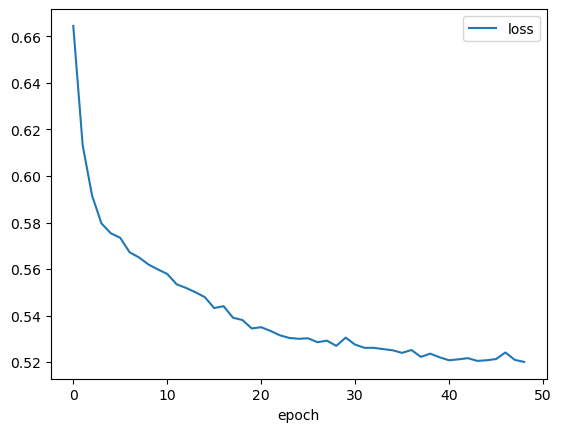

In [8]:
dfm.plot(x='epoch', y='loss')

# Validation phase

In [9]:
records, labels = load_h5_data(dataval)

idx_vid_val, X_val, y_val = process_data_with_windows(records)
y_val = y_val.squeeze()

db_val = AutismDataset(X_val, y_val,idx_vid_val, device=device)
val_loader = DataLoader(db_val, batch_size=BATCH_SIZE)


In [10]:
y_true, y_pred, videos = [], [],[]
with torch.no_grad():
    for batch_idx, (batch_X, batch_y, idx_video) in tqdm(enumerate(val_loader), 
                                              total=len(val_loader), 
                                              desc=f"Validation", 
                                              leave=False, disable=not(verbose)):
        y_pred.extend(model(batch_X).cpu().numpy().squeeze().round())
        y_true.extend(batch_y.cpu().numpy().squeeze())
        videos.extend(idx_video)

In [11]:
compute_validation(y_true, y_pred, videos, out, mapping)

,video,y_pred,y_true
0,8104,ASD,ASD
1,8117,TD,ASD
2,8121,ASD,ASD
3,8124,TD,ASD
4,8127,TD,ASD
5,8130,TD,ASD
6,8133,TD,ASD
7,8107,TD,ASD
8,8137,ASD,ASD
9,8155,TD,ASD
